In [1]:
pwd

'/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

In [2]:
import numpy as np
import pickle
import pandas as pd
from matplotlib import  pyplot as plt
import  seaborn as sns
from helper_funcs import *

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from scipy import stats

In [3]:
df = pd.read_csv('../Data/ABIDE_legend_S982_pca.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,...,Medication Name.1,Off stimulants at EPI scan?,ScanSite,ScannerType,ScannerID,ScanSiteID,ADOS_PCA,ADI_PCA,Vineland_PCA,WISC_PCA
0,0,0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,...,NaN,NaN,mpg,verio,7,3,0,0,0,0
1,1,1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,...,NaN,NaN,mpg,verio,7,3,0,0,0,0
2,2,2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,...,NaN,NaN,mpg,verio,7,3,0,0,0,0
3,3,3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,...,NaN,NaN,mpg,verio,7,3,0,0,0,0
4,4,4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,...,NaN,NaN,mpg,verio,7,3,0,0,0,0


In [4]:
subs = np.load('../Data/ABIDE-subs-982.npz')['subs']

In [5]:
assert len(subs)==len(df), 'diff lenghts'
assert all([subs[s]==df['BIDS_ID'].values[s] for s in range(len(df))]), 'bad order'

In [6]:
patients = df['DxGroup'].values==1

In [7]:
fn = '../Data/embedded_data.pickle'
data = pickle.load(open(fn,'rb'))
np.array(list(data.keys()))

array(['embedding_bg', 'embedding_sl', 'embedding_vae',
       'sfari_embedding_vae', 'sfari_embedding_bg', 'sfari_embedding_sl',
       'bg_space_abide', 'sl_space_abide', 'vae_space_abide',
       'bg_space_sfari', 'sl_space_sfari', 'vae_space_sfari',
       'bg_Sspace_sfari', 'sl_Sspace_sfari', 'vae_Sspace_sfari',
       'reducer_bg_abide', 'reducer_sl_abide', 'reducer_vae_abide',
       'reducer_bg_sfari', 'reducer_sl_sfari', 'reducer_vae_sfari'],
      dtype='<U19')

In [8]:
for key in data.keys():
    try:
        print(f'{key} | {data[key].shape}')
    except:
        pass

embedding_bg | (470, 16)
embedding_sl | (470, 16)
embedding_vae | (470, 32)
sfari_embedding_vae | (51, 32)
sfari_embedding_bg | (51, 16)
sfari_embedding_sl | (51, 16)
bg_space_abide | (470, 2)
sl_space_abide | (470, 2)
vae_space_abide | (470, 2)
bg_space_sfari | (51, 2)
sl_space_sfari | (51, 2)
vae_space_sfari | (51, 2)
bg_Sspace_sfari | (51, 2)
sl_Sspace_sfari | (51, 2)
vae_Sspace_sfari | (51, 2)


In [9]:
#data_latent = np.load('../Data/latent_vecs100.npz')
data_latent = np.load('../Data/latent_vecs2.npz')
list(data_latent.keys())
print(data_latent['salient_vec_abide'].shape)

(10, 982, 16)


In [10]:
data_latent['salient_vec_abide'][0,:,:]

array([[-0.4272499 ,  0.2735272 , -2.7508783 , ..., -0.91731685,
         0.1433426 , -1.1449697 ],
       [-1.4786693 , -0.7763392 , -1.2325766 , ...,  0.0499858 ,
         0.5017805 ,  0.6354925 ],
       [-2.1715796 ,  1.5461673 ,  0.53020257, ..., -0.15939587,
        -0.6093791 , -0.77931774],
       ...,
       [-0.16703203,  0.08689937, -0.4655738 , ...,  1.1736007 ,
        -0.59409565, -1.0329659 ],
       [-1.2406087 , -0.45388728, -0.7552429 , ..., -1.2301507 ,
         0.5705857 , -2.9799838 ],
       [-1.0072553 , -0.18212083, -0.8699565 , ...,  1.8765252 ,
        -0.291705  , -0.71864563]], dtype=float32)

In [11]:
now = datetime.now
t0 = now()
print(t0)

2022-01-14 10:26:52.537445


In [12]:
%%capture
n = 10 
umap_mat = np.zeros((n,470,2))
for i in tqdm(range(n)):
    umap_mat[i,:,:] = data['reducer_sl_abide'].transform(data_latent['salient_vec_abide'][i,patients,:])

In [13]:
print(now())
print(now()-t0)

2022-01-14 10:27:30.060274
0:00:37.522914


In [14]:
umap_mat.shape

(10, 470, 2)

<ErrorbarContainer object of 3 artists>

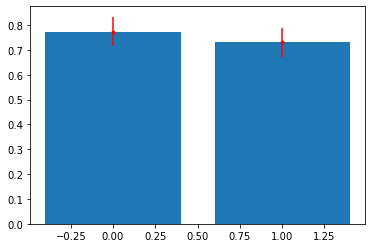

In [15]:
y = [get_triu(np.corrcoef(umap_mat[:,:,0])).mean(),get_triu(np.corrcoef(umap_mat[:,:,1])).mean()]
se = [get_triu(np.corrcoef(umap_mat[:,:,0])).std(),get_triu(np.corrcoef(umap_mat[:,:,1])).std()]
plt.bar([0,1],y)
plt.errorbar([0,1],y,se,fmt='r.')

In [16]:
def plot_scatters(x,ys,axs=None):
    plt.figure(figsize=np.array((10,5))*.85)
    
    if type(axs)!=type(None):
        plt.sca(axs[0])
    else:
        plt.subplot(2,2,3)
        
        
    plt.scatter(x,ys[0])
    m,b = np.polyfit(x, ys[0], 1)
    plt.plot(x,m*x+b,'r-',linewidth=3)
    
    plt.xlabel(key)
    plt.ylabel('X axis loading')
    
    if type(axs)!=type(None):
        plt.sca(axs[1])
    else:
        plt.subplot(2,2,4)
        
    #x,y = vec[v],umap_mat[i,v,1]
    plt.scatter(x,ys[1])
    m,b = np.polyfit(x, ys[1], 1)
    plt.plot(x,m*x+b,'r-',linewidth=3)
    
    plt.xlabel(key)
    plt.ylabel('Y axis loading')

In [23]:
#n=10

In [18]:
def rdelta_stats(r_x,r_y):
    from scipy import stats
    t,p = stats.ttest_rel(abs(r_x),abs(r_y))
    rdelta = abs(r_x).mean()-abs(r_y).mean()

    if p < .001:
        print(f'{key} | Δr = {rdelta:.3f}, t(9) = {t:.2f}, p < .001')
    else:
        print(f'{key} | Δr = {rdelta:.3f}, t(9) = {t:.2f}, p = {p:.3f}')

In [19]:
def plot_error_bar(y,xlbls=None,title=None,axs=None):
    
    #plt.figure(figsize=np.array((10,5))*.75)
    if type(axs)!=type(None):
        plt.sca(axs[0])
        
    xs = np.arange(len(y))
    m = [val.mean() for val in y]
    se = [val.std() for val in y]
    m = [abs(val) for val in m]
    
    t,p = stats.ttest_1samp(y[0],0)
    star_idx = max(np.nonzero(np.float64(p) < [1,.05,.01,.001])[0])
    star_lbls = ['n.s','*','**','***']
    xlbls[0] = xlbls[0]+'\n'+star_lbls[star_idx]

    t,p = stats.ttest_1samp(y[1],0)
    star_idx = max(np.nonzero(np.float64(p) < [1,.05,.01,.001])[0])
    star_lbls = ['n.s','*','**','***']
    xlbls[1] = xlbls[1]+'\n'+star_lbls[star_idx]
    
    plt.bar(xs,m)
    plt.errorbar(xs,m,se,fmt='r.')
    plt.ylabel('r')
    
    #t,p = stats.ttest_rel(y[0],y[1])
    t,p = stats.ttest_rel(abs(y[0]),abs(y[1]))
    star_idx = max(np.nonzero(np.float64(p) < [1,.05,.01,.001])[0])
    yy = max(m)+max(se)
    yy = yy*1.1
    plt.plot([0,1],[yy,yy],'k-',linewidth=3)
    plt.text(.5,yy,star_lbls[star_idx],fontsize=24)
    
    if xlbls:
        plt.xticks(xs,labels=xlbls,fontsize=14)
    if title:
        plt.title(title,fontsize=12)
    plt.ylim(0,yy*1.2)

In [20]:
df['ADOS_PCA'][abs(df['ADOS_PCA'].values)<.1]=np.nan
df['ADI_PCA'][abs(df['ADI_PCA'].values)<.1]=np.nan
df['Vineland_PCA'][abs(df['Vineland_PCA'].values)<.1]=np.nan
df['WISC_PCA'][abs(df['WISC_PCA'].values)<.1]=np.nan

<ipython-input-20-d58d5123f0e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ADOS_PCA'][abs(df['ADOS_PCA'].values)<.1]=np.nan
<ipython-input-20-d58d5123f0e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ADI_PCA'][abs(df['ADI_PCA'].values)<.1]=np.nan
<ipython-input-20-d58d5123f0e7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vineland_PCA'][abs(df['Vineland_PCA'].values)<.1]=np.nan
<ipython-input-20-d58d5123f0e7>

ADOS_Total | Δr = -0.057, t(9) = -9.55, p < .001
ADOS_Comm | Δr = -0.001, t(9) = -0.17, p = 0.867
ADOS_Social | Δr = -0.065, t(9) = -11.20, p < .001
ADOS_StBeh | Δr = 0.085, t(9) = 7.74, p < .001


<Figure size 612x306 with 0 Axes>

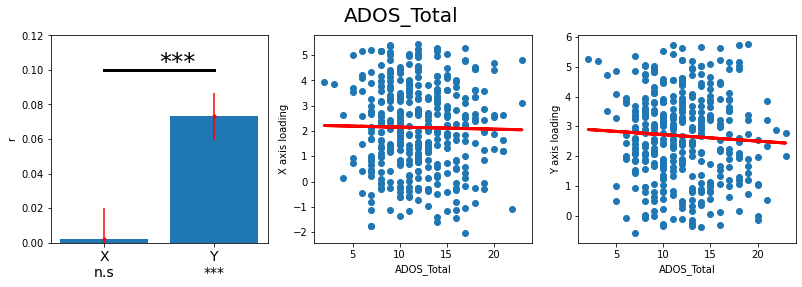

<Figure size 612x306 with 0 Axes>

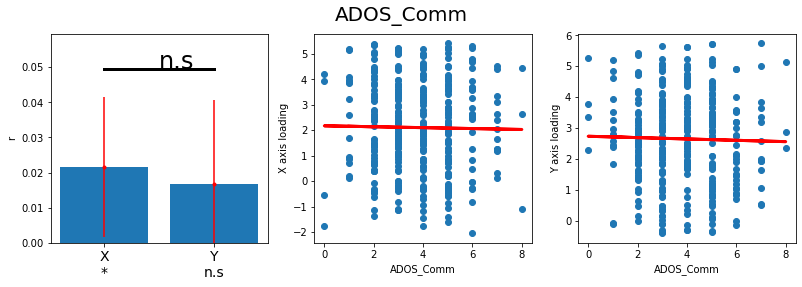

<Figure size 612x306 with 0 Axes>

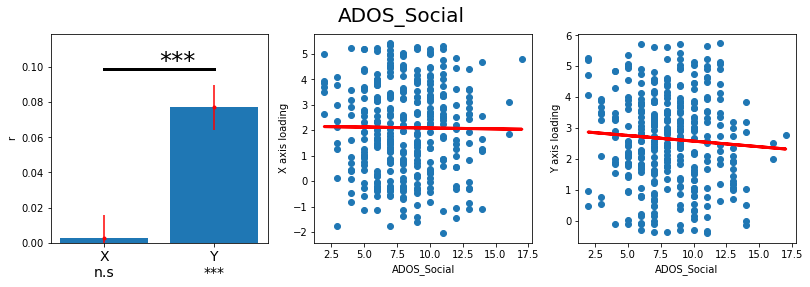

<Figure size 612x306 with 0 Axes>

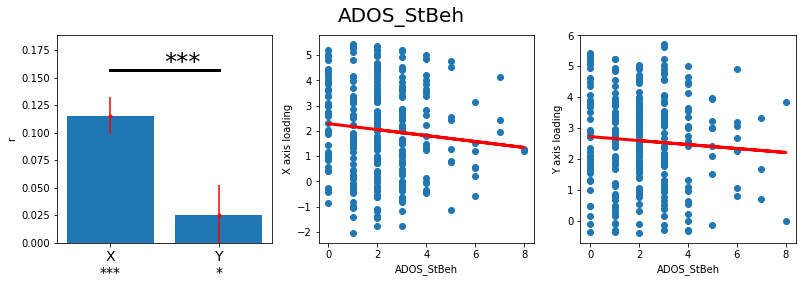

In [24]:
keys = ['AgeAtScan', 'FIQ', 'VIQ', 'PIQ','ADOS_PCA',
       'ADI_PCA', 'Vineland_PCA', 'WISC_PCA','ADOS_Total','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh', 'ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB',
       'ADI_R_Onset Total','SRS_RawTotal','SCQ_Total','VINELAND_Written_Vscore', 'VINELAND_CommunicationStandard',
       'VINELAND_Personal_Vscore', 'VINELAND_Domestic_Vscore',
       'VINELAND_Community_Vscore', 'VINELAND_DaylyLiving_Standard',
       'VINELAND_Interpersonal_Vscore', 'VINELAND_Play_Vscore',
       'VINELAND_Coping_Vscore', 'VINELAND_Socical_Standard',
       'VINELAND_Domestic_Standard', 'VINELAND_ABC_Standard',
       'VINELAND_Informant', 'ADOSGotham_SocAffect', 'ADOSGotham_Rest-RepBeh',
       'ADOSGotham_Total', 'ADOSGotham_Severity','AQ Total', 'SRS_awareness', 'SRS_cognition', 'SRS_communication',
       'SRS_motivation', 'SRS_manierisms', 'WISC4 VCI Verbal Comprehension Index',
       'WISC4 PRI Perceptual Reasoning Index',
       'WISC4 WMI Working Memory Index', 'WISC4 PSI Processing Speed Index',
       'WISC4 Sim Scaled', 'WISC4 Vocab Scaled', 'WISC4 Info Scaled',
       'WISC4 Blk Dsn Scaled', 'WISC4 Pic Con Scaled', 'WISC4 Matrix Scaled',
       'WISC4 Dig Span Scaled', 'WISC4 Let Num Scaled', 'WISC4 Coding Scaled',
       'WISC4 Sym Scaled']

keys = ['ADOS_Total','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh']


for key in keys:
    fig = plt.figure(figsize=np.array((15,5))*.75)
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)

    vec = df[key].values[patients]
    v = ~np.isnan(vec)
    r_x = np.array([np.corrcoef(vec[v],umap_mat[i,v,0])[0,1] for i in range(n)])
    r_y = np.array([np.corrcoef(vec[v],umap_mat[i,v,1])[0,1] for i in range(n)])
    plt.sca(ax1)
    plot_error_bar([r_x,r_y],xlbls=['X','Y'])
    plot_scatters(vec[v],[umap_mat[i,v,0],umap_mat[i,v,1]],axs=[ax2,ax3])
    rdelta_stats(r_x,r_y)
    plt.tight_layout()
    plt.suptitle(key,fontsize=20,y=1.05)

In [22]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'index', 'BIDS_ID', 'Anonymized ID',
       'Subject Type', 'Visit', 'Days since enrollment', 'SubID', 'DxGroup',
       'DSMIVTR', 'AgeAtScan', 'Sex', 'FIQ', 'VIQ', 'PIQ', 'IQTest', 'VIQTest',
       'PIQTest', 'ADOS_Module', 'ADOS_Total', 'ADOS_ResearchReliability',
       'ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB',
       'ADI_R_Onset Total', 'ADI_R_ResearchReliability', 'Handedness_Category',
       'Handedness_Scores', 'ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh',
       'Comorbid_adhd', 'Comorbid_phobia', 'comorbid_anxiety', 'comorbid_all',
       'comorbid_other', 'Comorbidity', 'SRS_RawTotal', 'SRS_Version',
       'SCQ_Total', 'VINELAND_Receptive_Vscore', 'VINELAND_Expressive_Vscore',
       'VINELAND_Written_Vscore', 'VINELAND_CommunicationStandard',
       'VINELAND_Personal_Vscore', 'VINELAND_Domestic_Vscore',
       'VINELAND_Community_Vscore', 'VINELAND_DaylyLiving_Standard',
       'VINELAND_Interpersonal_Vscore', 'VINELAND_Pla

In [23]:
import sklearn

In [24]:
PCA = sklearn.decomposition.PCA

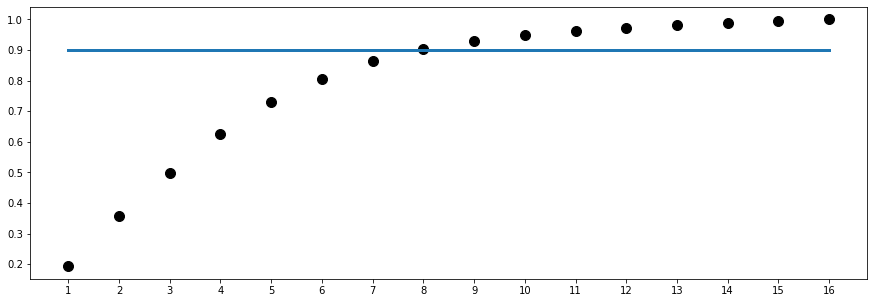

In [25]:
pca = PCA()
comp = pca.fit_transform(data['embedding_bg'])
y = np.cumsum(pca.explained_variance_ratio_)
n = len(y)
x = np.arange(n)
plt.figure(figsize=(15,5))
plt.plot(y,'k.',markersize=20);
plt.plot(x,np.repeat(.9,n),linewidth=3);
plt.xticks(x,labels=x+1);

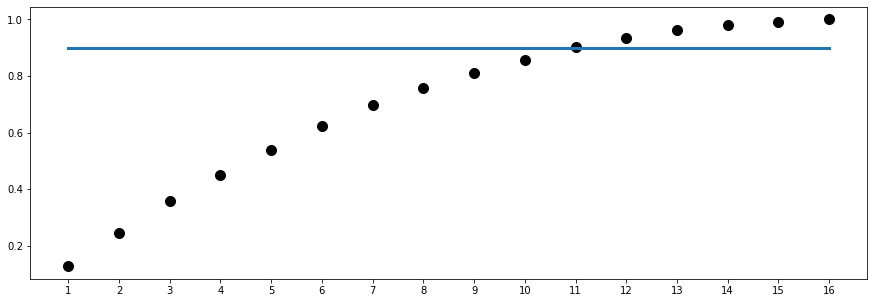

In [26]:
pca = PCA()
comp = pca.fit_transform(data['embedding_sl'])
y = np.cumsum(pca.explained_variance_ratio_)
n = len(y)
x = np.arange(n)
plt.figure(figsize=(15,5))
plt.plot(y,'k.',markersize=20);
plt.plot(x,np.repeat(.9,n),linewidth=3);
plt.xticks(x,labels=x+1);

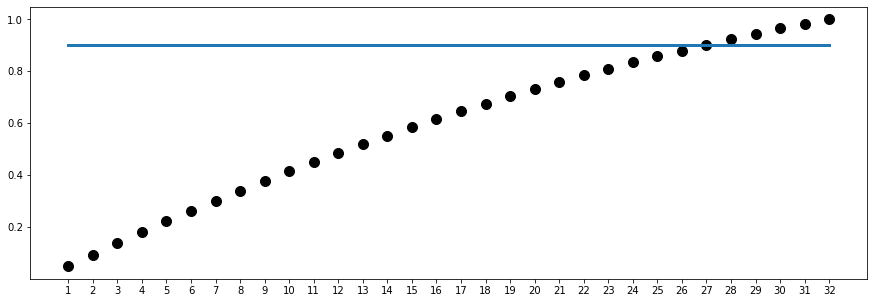

In [27]:
pca = PCA()
comp = pca.fit_transform(data['embedding_vae'])
y = np.cumsum(pca.explained_variance_ratio_)
n = len(y)
x = np.arange(n)
plt.figure(figsize=(15,5))
plt.plot(y,'k.',markersize=20);
plt.plot(x,np.repeat(.9,n),linewidth=3);
plt.xticks(x,labels=x+1);

In [28]:
umap_mat.shape

(10, 470, 2)

In [29]:
# Zobserved = (z1 – z2) / (square root of [ (1 / N1 – 3) + (1 / N2 – 3) ]

In [30]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'index', 'BIDS_ID', 'Anonymized ID',
       'Subject Type', 'Visit', 'Days since enrollment', 'SubID', 'DxGroup',
       'DSMIVTR', 'AgeAtScan', 'Sex', 'FIQ', 'VIQ', 'PIQ', 'IQTest', 'VIQTest',
       'PIQTest', 'ADOS_Module', 'ADOS_Total', 'ADOS_ResearchReliability',
       'ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB',
       'ADI_R_Onset Total', 'ADI_R_ResearchReliability', 'Handedness_Category',
       'Handedness_Scores', 'ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh',
       'Comorbid_adhd', 'Comorbid_phobia', 'comorbid_anxiety', 'comorbid_all',
       'comorbid_other', 'Comorbidity', 'SRS_RawTotal', 'SRS_Version',
       'SCQ_Total', 'VINELAND_Receptive_Vscore', 'VINELAND_Expressive_Vscore',
       'VINELAND_Written_Vscore', 'VINELAND_CommunicationStandard',
       'VINELAND_Personal_Vscore', 'VINELAND_Domestic_Vscore',
       'VINELAND_Community_Vscore', 'VINELAND_DaylyLiving_Standard',
       'VINELAND_Interpersonal_Vscore', 'VINELAND_Pla

In [31]:
key_list = ['AgeAtScan','FIQ','ADOS_Total','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh','ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB','ADI_R_Onset Total',
          'SRS_RawTotal',
       'SCQ_Total',
           'ADOSGotham_SocAffect', 'ADOSGotham_Rest-RepBeh',
       'ADOSGotham_Total', 'ADOSGotham_Severity',
       'AQ Total','ADOS_PCA',
       'ADI_PCA', 'Vineland_PCA', 'WISC_PCA']

key_list = ['AgeAtScan','FIQ','ADOS_Total','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh','ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB','ADI_R_Onset Total',
          'SRS_RawTotal',
       'SCQ_Total',
           'ADOSGotham_SocAffect', 'ADOSGotham_Rest-RepBeh',
       'ADOSGotham_Total', 'ADOSGotham_Severity',
       'AQ Total','ADOS_PCA',
       'ADI_PCA', 'Vineland_PCA', 'WISC_PCA','VINELAND_Written_Vscore', 'VINELAND_CommunicationStandard',
       'VINELAND_Personal_Vscore', 'VINELAND_Domestic_Vscore',
       'VINELAND_Community_Vscore', 'VINELAND_DaylyLiving_Standard',
       'VINELAND_Interpersonal_Vscore', 'VINELAND_Play_Vscore',
       'VINELAND_Coping_Vscore', 'VINELAND_Socical_Standard',
       'VINELAND_Domestic_Standard', 'VINELAND_ABC_Standard','WISC4 VCI Verbal Comprehension Index',
       'WISC4 PRI Perceptual Reasoning Index',
       'WISC4 WMI Working Memory Index', 'WISC4 PSI Processing Speed Index',
       'WISC4 Sim Scaled', 'WISC4 Vocab Scaled', 'WISC4 Info Scaled',
       'WISC4 Blk Dsn Scaled', 'WISC4 Pic Con Scaled', 'WISC4 Matrix Scaled',
       'WISC4 Dig Span Scaled', 'WISC4 Let Num Scaled', 'WISC4 Coding Scaled',
       'WISC4 Sym Scaled','VIQ', 'PIQ']

In [32]:
key

'WISC4 Sym Scaled'

In [33]:
r_list = np.zeros((len(key_list),5))
for idx,key in enumerate(key_list):
    vec = df[key].values[patients]
    v = ~np.isnan(vec)
#     r1 = np.corrcoef(vec[v],umap_mat[0,v,0])[0,1]
#     r2 = np.corrcoef(vec[v],umap_mat[0,v,1])[0,1]

    pr1 = stats.pearsonr(vec[v],umap_mat[0,v,0])
    pr2 = stats.pearsonr(vec[v],umap_mat[0,v,1])
    r_list[idx,0] = pr1[0]
    r_list[idx,1] = pr2[0]
    
    r_list[idx,2] = pr1[1]
    r_list[idx,3] = pr2[1]
    
    r_list[idx,4] = len(vec[v])

In [34]:
dr = pd.DataFrame()

In [35]:
dr['key'] = key_list
dr['rx'] = abs(r_list[:,0])
dr['ry'] = abs(r_list[:,1])
dr['rdelta'] = abs(r_list[:,0])-abs(r_list[:,1])

dr['px'] = r_list[:,2]
dr['py'] = r_list[:,3]
dr['n'] = r_list[:,4]

In [36]:
dr = dr[dr['n']>100]

In [37]:
dr

,key,rx,ry,rdelta,px,py,n
0,AgeAtScan,0.033491,0.069447,-0.035956,0.468860,0.132742,470.0
1,FIQ,0.083872,0.069664,0.014208,0.083073,0.150220,428.0
2,ADOS_Total,0.040569,0.125873,-0.085304,0.437173,0.015548,369.0
3,ADOS_Comm,0.035994,0.054120,-0.018127,0.505813,0.316893,344.0
4,ADOS_Social,0.041764,0.122729,-0.080965,0.439373,0.022611,345.0
5,ADOS_StBeh,0.120100,0.000635,0.119465,0.042770,0.991486,285.0
6,ADI_R_SocialTotal,0.062295,0.025227,0.037068,0.274200,0.658168,310.0
7,ADI_R_VerbalTotal,0.002839,0.015900,-0.013061,0.960234,0.780028,311.0
8,ADI_R_RRB,0.080997,0.039812,0.041185,0.154832,0.484922,310.0
9,ADI_R_Onset Total,0.034796,0.042932,-0.008136,0.559933,0.471915,283.0


In [38]:
dr.head()

,key,rx,ry,rdelta,px,py,n
0,AgeAtScan,0.033491,0.069447,-0.035956,0.468860,0.132742,470.0
1,FIQ,0.083872,0.069664,0.014208,0.083073,0.150220,428.0
2,ADOS_Total,0.040569,0.125873,-0.085304,0.437173,0.015548,369.0
3,ADOS_Comm,0.035994,0.054120,-0.018127,0.505813,0.316893,344.0
4,ADOS_Social,0.041764,0.122729,-0.080965,0.439373,0.022611,345.0


In [39]:
dr.sort_values(by='px',ascending=True).head(5)

,key,rx,ry,rdelta,px,py,n
5,ADOS_StBeh,0.120100,0.000635,0.119465,0.042770,0.991486,285.0
1,FIQ,0.083872,0.069664,0.014208,0.083073,0.150220,428.0
14,ADOSGotham_Total,0.106902,0.153213,-0.046311,0.135873,0.032038,196.0
8,ADI_R_RRB,0.080997,0.039812,0.041185,0.154832,0.484922,310.0
15,ADOSGotham_Severity,0.097642,0.178203,-0.080560,0.173354,0.012458,196.0


In [40]:
dr.sort_values(by='py',ascending=True).head(5)

,key,rx,ry,rdelta,px,py,n
15,ADOSGotham_Severity,0.097642,0.178203,-0.080560,0.173354,0.012458,196.0
2,ADOS_Total,0.040569,0.125873,-0.085304,0.437173,0.015548,369.0
4,ADOS_Social,0.041764,0.122729,-0.080965,0.439373,0.022611,345.0
14,ADOSGotham_Total,0.106902,0.153213,-0.046311,0.135873,0.032038,196.0
17,ADOS_PCA,0.026620,0.132728,-0.106108,0.679056,0.038284,244.0


In [41]:
dr.sort_values(by='rdelta',ascending=False).head()

,key,rx,ry,rdelta,px,py,n
5,ADOS_StBeh,0.120100,0.000635,0.119465,0.042770,0.991486,285.0
8,ADI_R_RRB,0.080997,0.039812,0.041185,0.154832,0.484922,310.0
6,ADI_R_SocialTotal,0.062295,0.025227,0.037068,0.274200,0.658168,310.0
48,PIQ,0.050082,0.026051,0.024031,0.325779,0.609418,387.0
1,FIQ,0.083872,0.069664,0.014208,0.083073,0.150220,428.0


In [42]:
dr_sorted = dr.sort_values(by='rdelta',ascending=True)
dr_sorted.head()

,key,rx,ry,rdelta,px,py,n
17,ADOS_PCA,0.026620,0.132728,-0.106108,0.679056,0.038284,244.0
10,SRS_RawTotal,0.033635,0.138826,-0.105192,0.645017,0.056105,190.0
2,ADOS_Total,0.040569,0.125873,-0.085304,0.437173,0.015548,369.0
4,ADOS_Social,0.041764,0.122729,-0.080965,0.439373,0.022611,345.0
15,ADOSGotham_Severity,0.097642,0.178203,-0.080560,0.173354,0.012458,196.0


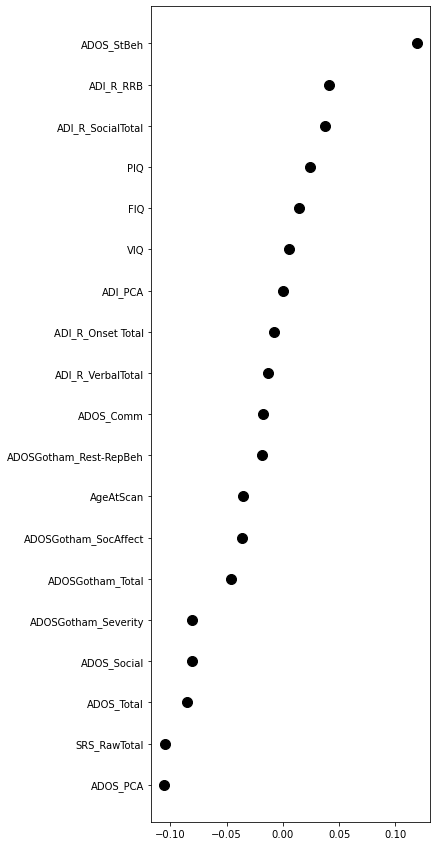

In [43]:
y = dr_sorted['rdelta'].values
x = np.arange(len(y))
lbls = dr_sorted['key'].values

plt.figure(figsize=(5,15))
plt.plot(y,x,'k.',markersize=20)
plt.yticks(x,labels=lbls,rotation=0);

In [44]:
dr.sort_values(by='rx',ascending=False).head()

,key,rx,ry,rdelta,px,py,n
5,ADOS_StBeh,0.120100,0.000635,0.119465,0.042770,0.991486,285.0
14,ADOSGotham_Total,0.106902,0.153213,-0.046311,0.135873,0.032038,196.0
15,ADOSGotham_Severity,0.097642,0.178203,-0.080560,0.173354,0.012458,196.0
12,ADOSGotham_SocAffect,0.094068,0.130467,-0.036399,0.190857,0.069073,195.0
1,FIQ,0.083872,0.069664,0.014208,0.083073,0.150220,428.0


In [45]:
dr.sort_values(by='ry',ascending=False).head()

,key,rx,ry,rdelta,px,py,n
15,ADOSGotham_Severity,0.097642,0.178203,-0.080560,0.173354,0.012458,196.0
14,ADOSGotham_Total,0.106902,0.153213,-0.046311,0.135873,0.032038,196.0
10,SRS_RawTotal,0.033635,0.138826,-0.105192,0.645017,0.056105,190.0
17,ADOS_PCA,0.026620,0.132728,-0.106108,0.679056,0.038284,244.0
12,ADOSGotham_SocAffect,0.094068,0.130467,-0.036399,0.190857,0.069073,195.0


In [46]:
import scipy

In [47]:
linkage = scipy.cluster.hierarchy.linkage
dendrogram = scipy.cluster.hierarchy.dendrogram

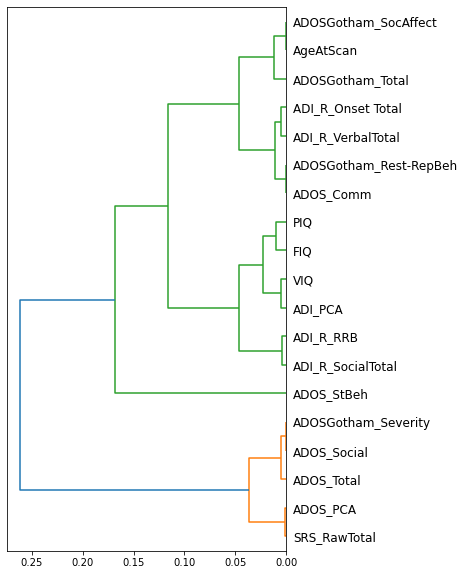

In [48]:
plt.figure(figsize=(5,10))
Z = linkage(1-dr['rdelta'].values[:,np.newaxis],'ward')
dendrogram(Z,0,orientation='left',labels=dr['key'].values);

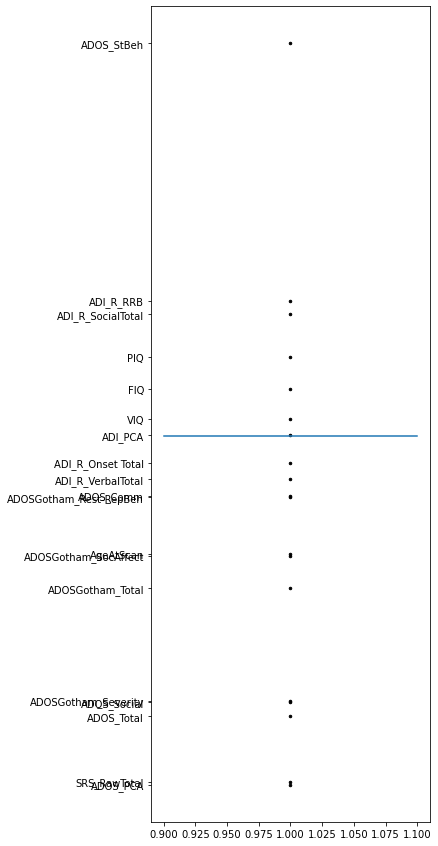

In [49]:
dr = dr[dr['n']>150]
c = len(dr)
plt.figure(figsize=(5,15))
plt.plot(np.ones(c),dr['rdelta'].values,'k.',markersize=5)
plt.yticks(dr['rdelta'].values,labels=dr['key'].values,rotation=0);
plt.plot([.9,1.1],[0,0])

In [50]:
## REGRESSION with 16 dimensions

In [51]:
list(data_latent.keys())

['salient_vec_abide',
 'background_vec_abide',
 'vae_vec_abide',
 'salient_vec_sfari',
 'background_vec_sfari',
 'vae_vec_sfari']

In [52]:
data_latent['salient_vec_abide'].shape

(10, 982, 16)

In [53]:
# >>> import numpy as np
# >>> from sklearn.linear_model import LinearRegression
# >>> X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# >>> # y = 1 * x_0 + 2 * x_1 + 3
# >>> y = np.dot(X, np.array([1, 2])) + 3
# >>> reg = LinearRegression().fit(X, y)
# >>> reg.score(X, y)
# 1.0
# >>> reg.coef_
# array([1., 2.])
# >>> reg.intercept_
# 3.0...
# >>> reg.predict(np.array([[3, 5]]))
# array([16.])

In [54]:
keys = ['AgeAtScan', 'Sex', 'FIQ', 'VIQ', 'PIQ','ADOS_Total', 'ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh','SRS_awareness', 'SRS_cognition', 'SRS_communication',
       'SRS_motivation', 'SRS_manierisms']

LinearRegression = sklearn.linear_model.LinearRegression

coefss = list()
for i in range(10):
    coefs = list()
    for key in keys:
       #X = data_latent['salient_vec_abide'][i,patients,:]
        X = data_latent['background_vec_abide'][0,patients,:]
        #X = data_latent['vae_vec_abide'][0,patients,:]
        Y = df[key].values[patients]
        v = ~np.isnan(Y)

        X = X[v,:]
        Y = Y[v]

        reg = LinearRegression().fit(X, Y)
        coefs.append(reg.coef_)
    coefss.append(coefs)

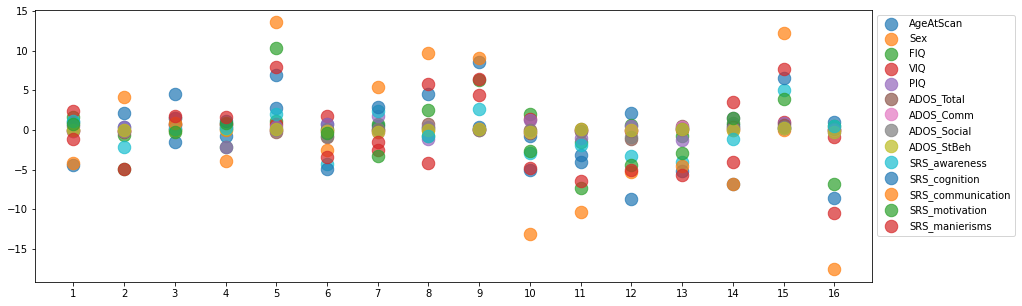

In [55]:
plt.figure(figsize=(15,5))
coef_mat = np.array(coefs).transpose()
coef_mat = np.array(coefss).mean(axis=0).transpose()
plt.plot(coef_mat,'.',markersize=25,alpha=.7)
plt.legend(keys,bbox_to_anchor=(1.0, 1), loc='upper left')
plt.xticks(np.arange(16),labels=np.arange(16)+1);

In [56]:
keys = ['Sex','DSMIVTR']

LinearRegression = sklearn.linear_model.LinearRegression
coefs = list()

for key in keys:
    X = data_latent['salient_vec_abide'][0,patients,:]
    #X = data_latent['background_vec_abide'][0,patients,:]
    #X = data_latent['vae_vec_abide'][0,patients,:]
    Y = df[key].values[patients]
    v = ~np.isnan(Y)

    X = X[v,:]
    Y = Y[v]

    reg = LinearRegression().fit(X, Y)
    coefs.append(reg.coef_)

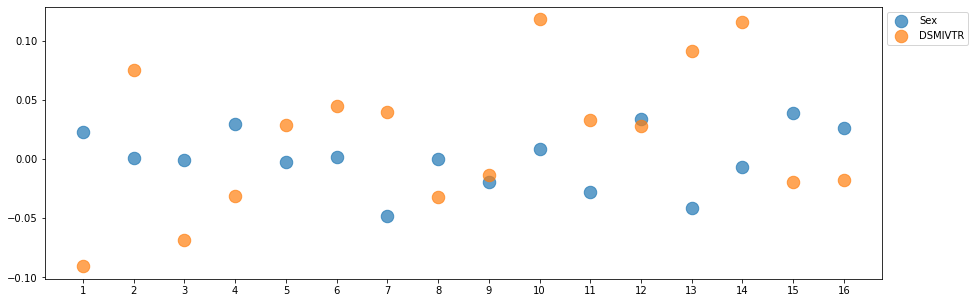

In [57]:
plt.figure(figsize=(15,5))
coef_mat = np.array(coefs).transpose()
plt.plot(coef_mat,'.',markersize=25,alpha=.7)
plt.legend(keys,bbox_to_anchor=(1.0, 1), loc='upper left')
plt.xticks(np.arange(16),labels=np.arange(16)+1);

In [58]:
# Y = scipy.spatial.distance.pdist(coef_mat.transpose(),metric='euclidean')
# Z = linkage(Y,'ward');
# dendrogram(Z,orientation='left',labels=keys);